In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

import matplotlib.pyplot as plt

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor


In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True)



h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Cal dates   : 2005-07-01 00:00:00 --- 2006-12-01 00:00:00  (n=18)
Test dates  : 2007-01-01 00:00:00 --- 2008-06-01 00:00:00  (n=18)


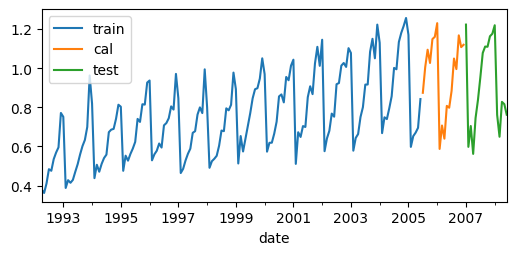

In [4]:
# ==============================================================================
test_steps = 18
cal_steps = 18
data_train = data[:-test_steps]
data_train, data_cal = data_train[0:-cal_steps], data_train[-cal_steps:]
data_test  = data[-test_steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)

print(
    f"Cal dates   : {data_cal.index.min()} --- "
    f"{data_cal.index.max()}  (n={len(data_cal)})"
)

print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')

ax.legend();

In [5]:
data_test['y'].name

'y'

In [6]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )

# we use 80% of the data for training and 20% for calibrating
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-06-04 19:34:07 
Last fit date: 2024-06-04 19:34:07 
Skforecast version: 0

# Predict without conformal

In [7]:
# Predictions
# ==============================================================================

non_cp_preds = forecaster.predict(steps=test_steps)
non_cp_preds_last_window = forecaster.predict(steps=test_steps, last_window=data_cal['y'])

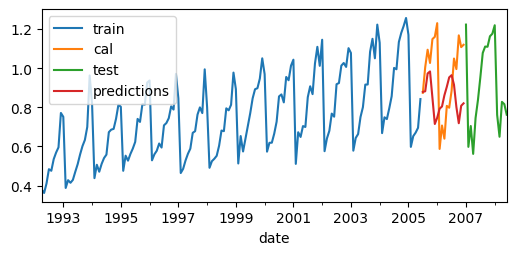

In [8]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_cal['y'].plot(ax=ax, label='cal')
data_test['y'].plot(ax=ax, label='test')
non_cp_preds.plot(ax=ax, label='predictions')
ax.legend();

# Predict with conformal


In [9]:
# data_cal['y']

In [10]:
# Calibrate
# ==============================================================================
forecaster.calibrate_conformal(data_cal['y'])


Last window of the calibration data has been stored in the model.


Conformal prediction has been calibrated. The model is now ready to predict conformal intervals.



In [11]:
forecaster.regressor_conformal.valid_methods_

['enbpi', 'aci']

In [12]:
# see estimator
forecaster.regressor_conformal.estimator

RandomForestRegressor(random_state=123)

In [13]:
forecaster.regressor_conformal.method  # this should be aci, I patch it by reassigning 'aci' to it.

'base'

In [22]:
# Predictions
# ==============================================================================
predictions = forecaster.predict_conformal_interval(steps=test_steps,
                                                    last_window = data_cal['y'],
                                                    desired_coverage= 0.9)
predictions.head()

,pred,lower_bound,upper_bound
2007-01-01,0.826099,0.713819,1.047965
2007-02-01,0.674059,0.561779,0.895925
2007-03-01,0.718522,0.606242,0.940388
2007-04-01,0.783988,0.671708,1.005855
2007-05-01,0.812170,0.699890,1.034037


In [15]:
preds, y_pis = predictions['pred'].to_numpy(), predictions[['lower_bound', 'upper_bound']].to_numpy()

In [18]:
# compare with non cp predictions to see if they are the same. They are not, which makes sense as we fit the model on a different data set.
# but they should be the same when we use the last_window argument.
print(np.isclose(preds, non_cp_preds.to_numpy()))
print(np.isclose(preds, non_cp_preds_last_window.to_numpy()))

[False False False False False False False False False False False False
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [20]:
data_test.index

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

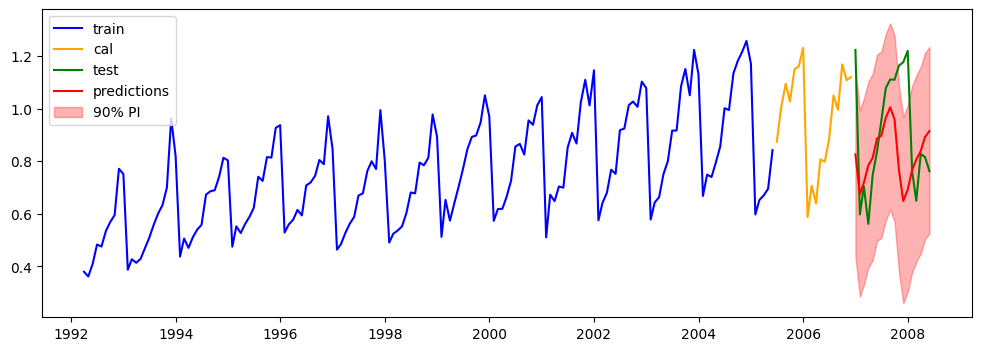

In [21]:
# visualize predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(data_train.index, data_train['y'], color='blue', label='train')
ax.plot(data_cal.index, data_cal['y'], color='orange', label='cal')
ax.plot(data_test.index, data_test['y'], color='green', label='test')

ax.plot(data_test.index, preds, color='red', label='predictions')

# plot intervals
ax.fill_between(data_test.index, lower, upper, color='red', alpha=0.3, label='90% PI')


ax.legend();
plt.show()
